In [167]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [168]:
hr_df = pd.read_csv('../../../../data/public_data/cleaned/fitbit/cleaned_heart_rate.csv')
hr_df['Time'] = pd.to_datetime(hr_df['Time'])

In [169]:
# resample to minute heart rate values from 15-20s
def get_mean_min_vals(group):
    mean_minute_vals = group.resample('1Min', on='Time')['Value'].mean() 
    return mean_minute_vals.to_frame()
    
hr_per_min_df = hr_df.groupby('Id').apply(get_mean_min_vals)
hr_per_min_df.head()

Value
Id         Time                           
2022484408 2016-04-01 07:54:00   99.600000
           2016-04-01 07:55:00  110.111111
           2016-04-01 07:56:00   92.555556
           2016-04-01 07:57:00   90.400000
           2016-04-01 07:58:00   97.875000

# Combine with minutes activity data

In [170]:
mins_df = pd.read_csv('../../../../data/public_data/cleaned/fitbit/cleaned_activity_minutes.csv')
# removing not needed data fields:
mins_df = mins_df.drop(columns=['Calories', 'METs', 'Steps'])
# rename index for merging
hr_per_min_df.index.names = ['Id', 'ActivityMinute']
mins_df['ActivityMinute'] = pd.to_datetime(mins_df['ActivityMinute'])
mins_df = mins_df.set_index(['Id', 'ActivityMinute'])

hr_intensity_df = pd.merge(hr_per_min_df, mins_df, left_index=True, right_index=True)
hr_intensity_df = hr_intensity_df.reset_index().set_index('Id')
hr_intensity_df.head()

,ActivityMinute,Value,Intensity
Id,,,
2022484408,2016-04-01 07:54:00,99.600000,1
2022484408,2016-04-01 07:55:00,110.111111,1
2022484408,2016-04-01 07:56:00,92.555556,1
2022484408,2016-04-01 07:57:00,90.400000,0
2022484408,2016-04-01 07:58:00,97.875000,1


In [171]:
hr_intensity_df.isna().sum()

ActivityMinute         0
Value             293706
Intensity              0
dtype: int64

In [172]:
# drop null cases - non existant hr values don't provide use for hr indicators
hr_intensity_df = hr_intensity_df.dropna()
hr_intensity_df.isna().sum()

ActivityMinute    0
Value             0
Intensity         0
dtype: int64

In [173]:
# get previous and next values in aim to remove some intensity drops
hr_intensity_df['prev_intensity'] = hr_intensity_df['Intensity'].shift(1)
hr_intensity_df['prev2_intensity'] = hr_intensity_df['Intensity'].shift(2)
hr_intensity_df['prev3_intensity'] = hr_intensity_df['Intensity'].shift(3)

hr_intensity_df['next_intensity'] = hr_intensity_df['Intensity'].shift(-1)
hr_intensity_df['next2_intensity'] = hr_intensity_df['Intensity'].shift(-2)
hr_intensity_df['next3_intensity'] = hr_intensity_df['Intensity'].shift(-3)

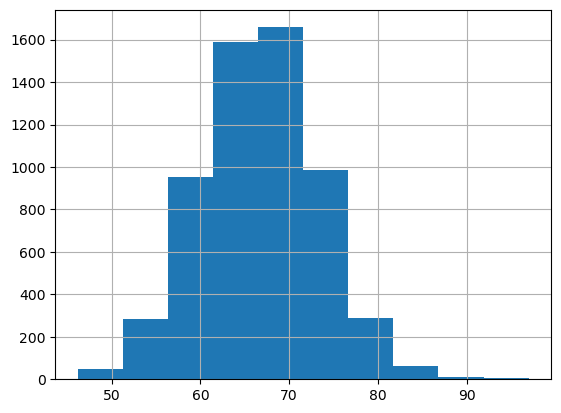

In [174]:
hr_intensity_df = hr_intensity_df.reset_index()
hr_intensity_df[(hr_intensity_df['Id'] == 2022484408) & (hr_intensity_df['Intensity'] == 0) & 
                (hr_intensity_df['prev_intensity'] == 0) & 
                (hr_intensity_df['prev2_intensity'] == 0) &
                (hr_intensity_df['prev3_intensity'] == 0) &
                (hr_intensity_df['next_intensity'] == 0) &
                (hr_intensity_df['next2_intensity'] == 0) &
                (hr_intensity_df['next3_intensity'] == 0)
                ]['Value'].hist()
plt.show()

In [175]:
def get_max_hr(group):
    return group['Value'].max()

def get_min_hr(group):
    return group['Value'].min()

max_hr = hr_intensity_df.groupby(['Id', hr_intensity_df['ActivityMinute'].dt.date]).apply(get_max_hr)
max_hr.name = 'Max Hr'
max_hr_df = max_hr.to_frame()
# median_hrs_df = pd.merge(median_hrs_df, max_hr_df, left_index=True, right_index=True)


min_hr = hr_intensity_df.groupby(['Id', hr_intensity_df['ActivityMinute'].dt.date]).apply(get_min_hr)
min_hr.name = 'Min Hr'
min_hr_df = min_hr.to_frame()
min_max_hr_df = pd.merge(max_hr_df, min_hr_df, left_index=True, right_index=True)

min_max_hr_df

Max Hr     Min Hr
Id         ActivityMinute                       
2022484408 2016-04-01      174.600000  55.500000
           2016-04-02       98.333333  50.333333
           2016-04-03      124.333333  50.000000
           2016-04-04      147.375000  55.000000
           2016-04-05      140.500000  54.333333
...                               ...        ...
8877689391 2016-05-08      128.600000  55.571429
           2016-05-09      173.521739  52.500000
           2016-05-10      137.666667  52.142857
           2016-05-11      176.565217  49.555556
           2016-05-12      118.500000  54.375000

[469 rows x 2 columns]

In [176]:
def get_daily_total_intensity(group):
    return group['Intensity'].sum()

total_daily_intensity = hr_intensity_df.groupby(['Id', hr_intensity_df['ActivityMinute'].dt.date]).apply(get_daily_total_intensity)
total_daily_intensity

Id          ActivityMinute
2022484408  2016-04-01        459
            2016-04-02        236
            2016-04-03        398
            2016-04-04        455
            2016-04-05        480
                             ... 
8877689391  2016-05-08        304
            2016-05-09        474
            2016-05-10        299
            2016-05-11        501
            2016-05-12        188
Length: 469, dtype: int64

In [177]:
total_daily_intensity.name = 'Daily Total Intensity'
total_daily_intensity_df = total_daily_intensity.to_frame()
total_daily_intensity_df

Daily Total Intensity
Id         ActivityMinute                       
2022484408 2016-04-01                        459
           2016-04-02                        236
           2016-04-03                        398
           2016-04-04                        455
           2016-04-05                        480
...                                          ...
8877689391 2016-05-08                        304
           2016-05-09                        474
           2016-05-10                        299
           2016-05-11                        501
           2016-05-12                        188

[469 rows x 1 columns]

In [178]:
min_max_hr_intensity_df = pd.merge(min_max_hr_df, total_daily_intensity_df, left_index=True, right_index=True)
min_max_hr_intensity_df.head()


Max Hr     Min Hr  Daily Total Intensity
Id         ActivityMinute                                              
2022484408 2016-04-01      174.600000  55.500000                    459
           2016-04-02       98.333333  50.333333                    236
           2016-04-03      124.333333  50.000000                    398
           2016-04-04      147.375000  55.000000                    455
           2016-04-05      140.500000  54.333333                    480

In [179]:
min_max_hr_intensity_df.isna().sum()

Max Hr                   0
Min Hr                   0
Daily Total Intensity    0
dtype: int64

In [180]:
min_max_hr_intensity_df = min_max_hr_intensity_df.reset_index(drop=True)
min_max_hr_intensity_df.head()

,Max Hr,Min Hr,Daily Total Intensity
0,174.600000,55.500000,459
1,98.333333,50.333333,236
2,124.333333,50.000000,398
3,147.375000,55.000000,455
4,140.500000,54.333333,480


In [181]:
min_max_hr_intensity_df.describe()

,Max Hr,Min Hr,Daily Total Intensity
count,469.000000,469.000000,469.000000
mean,132.708367,54.796699,345.328358
std,21.663556,7.555009,167.582773
min,76.714286,36.800000,0.000000
25%,118.625000,50.333333,232.000000
50%,129.125000,54.166667,359.000000
75%,146.416667,58.500000,452.000000
max,202.166667,83.571429,904.000000


# Feature Scaling and Transformation

/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_68458/342864433.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  min_max_hr_intensity_df.hist(ax=axis, bins=20)


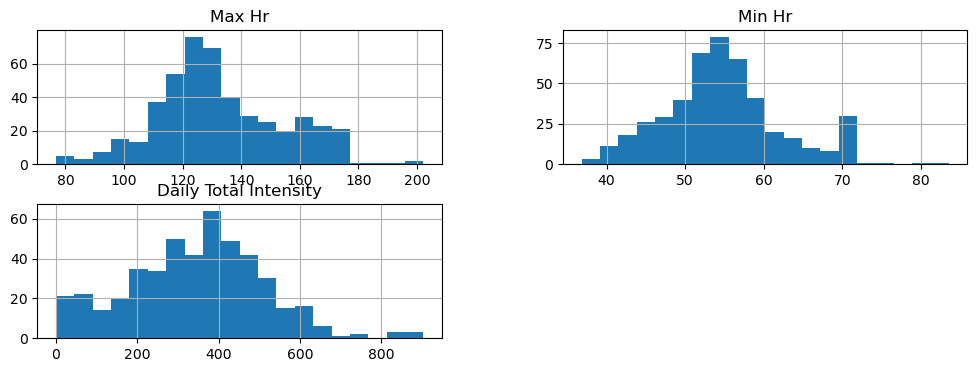

In [182]:
# inspecting the distribution of each feature:
fig, axis = plt.subplots(figsize=(12, 4))
min_max_hr_intensity_df.hist(ax=axis, bins=20)
plt.show()

In [183]:
min_max_hr_intensity_df.skew()

Max Hr                   0.329135
Min Hr                   0.479077
Daily Total Intensity    0.125852
dtype: float64

In [185]:
min_max_hr_intensity_df['Max Hr'] = box_cox_transformation(feature="Max Hr", l=0.3)
min_max_hr_intensity_df['Min Hr'] = box_cox_transformation(feature="Min Hr", l=-0.1)
min_max_hr_intensity_df['Daily Total Intensity'] = box_cox_transformation(feature="Daily Total Intensity", l=0.93)

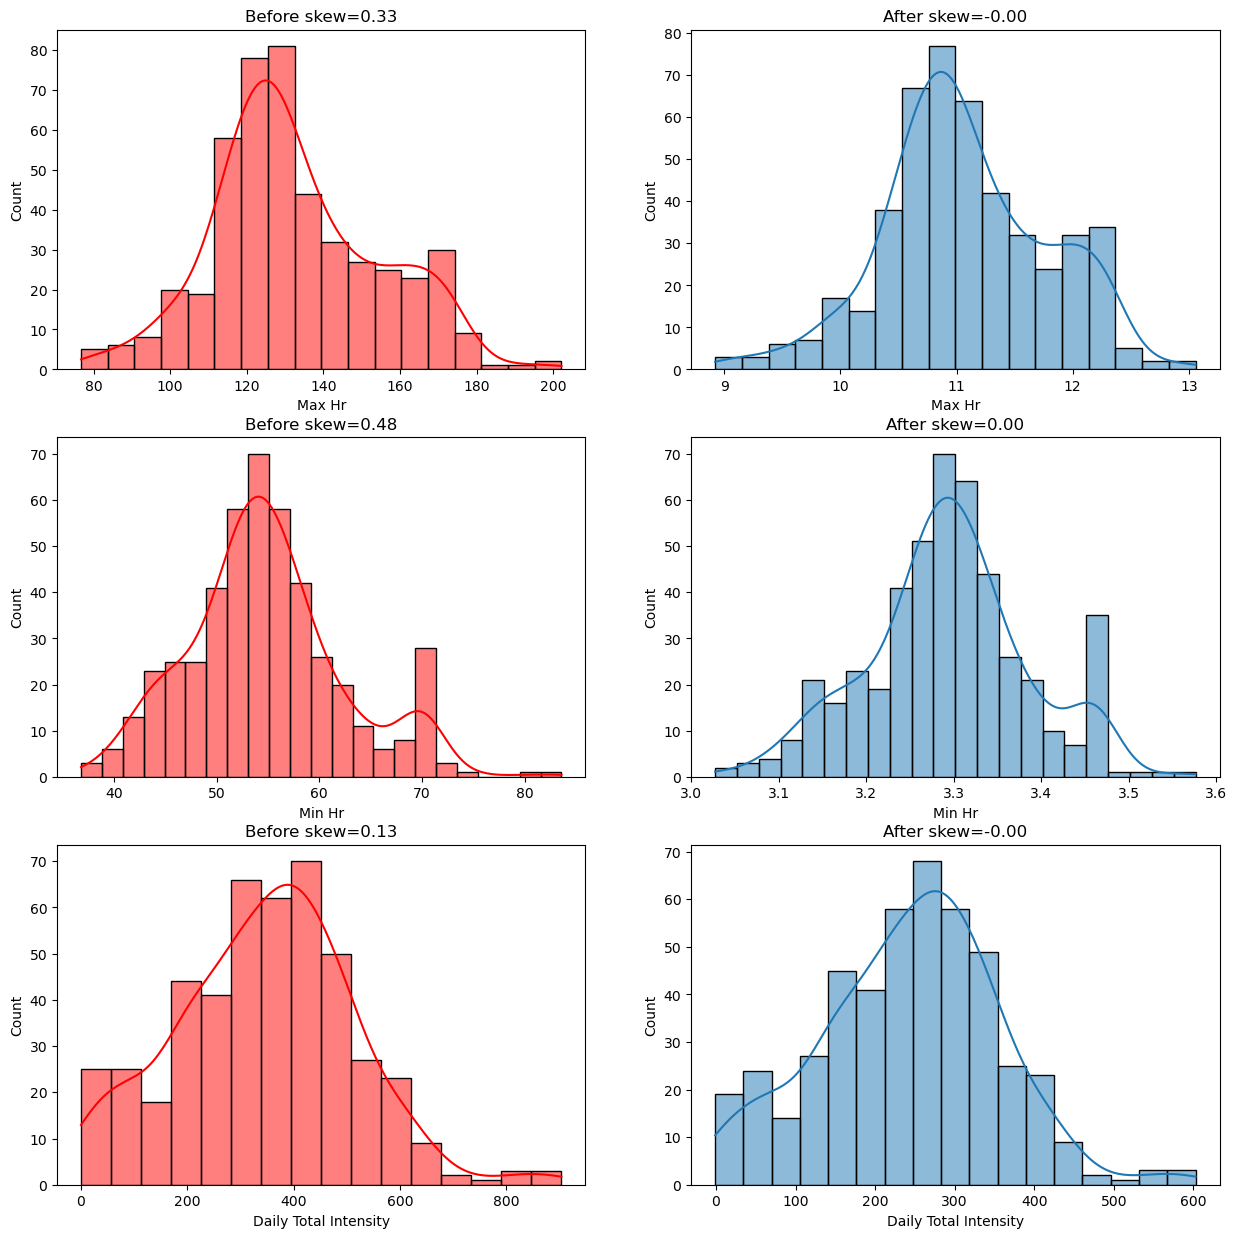

In [186]:

fig, ax = plt.subplots(3, 2, figsize=(15,15))
# activity_steps_df.hist(ax=ax, bins=20)
sns.histplot(before_unskewed_df['Max Hr'], kde=True, ax=ax[0,0], color='red').set(title=f"Before skew={before_unskewed_df['Max Hr'].skew():0.2f}")
sns.histplot(min_max_hr_intensity_df['Max Hr'], kde=True, ax=ax[0,1]).set(title=f"After skew={min_max_hr_intensity_df['Max Hr'].skew():0.2f}")

sns.histplot(before_unskewed_df['Min Hr'], kde=True, ax=ax[1,0], color='red').set(title=f"Before skew={before_unskewed_df['Min Hr'].skew():0.2f}")
sns.histplot(min_max_hr_intensity_df['Min Hr'], kde=True, ax=ax[1,1]).set(title=f"After skew={min_max_hr_intensity_df['Min Hr'].skew():0.2f}")


sns.histplot(before_unskewed_df['Daily Total Intensity'], kde=True, ax=ax[2,0], color='red').set(title=f"Before skew={before_unskewed_df['Daily Total Intensity'].skew():0.2f}")
sns.histplot(min_max_hr_intensity_df['Daily Total Intensity'], kde=True, ax=ax[2,1]).set(title=f"After skew={min_max_hr_intensity_df['Daily Total Intensity'].skew():0.2f}")


plt.show()

In [187]:
min_max_hr_intensity_df.describe()

,Max Hr,Min Hr,Daily Total Intensity
count,469.000000,469.000000,469.000000
mean,11.072384,3.292340,243.337367
std,0.707285,0.091685,112.484802
min,8.922465,3.027071,-1.075269
25%,10.634583,3.242058,169.305619
50%,10.994544,3.291479,254.638957
75%,11.545055,3.342910,315.732480
max,13.057144,3.576167,602.530931


# Scaling the features

In [188]:
scaler = StandardScaler()
scaled_intensity_hr = scaler.fit_transform(min_max_hr_intensity_df)
scaled_intensity_hr

array([[ 1.81103599,  0.16850043,  0.68487207],
       [-1.70158254, -0.54900195, -0.63455287],
       [-0.33892917, -0.59804636,  0.32965778],
       ...,
       [ 0.28328653, -0.28884832, -0.25534876],
       [ 1.8857058 , -0.66400132,  0.92750092],
       [-0.62590184,  0.01871141, -0.92820769]])

In [189]:
scaled_intensity_hr_df = pd.DataFrame(scaled_intensity_hr, columns=min_max_hr_intensity_df.columns)
scaled_intensity_hr_df

,Max Hr,Min Hr,Daily Total Intensity
0,1.811036,0.168500,0.684872
1,-1.701583,-0.549002,-0.634553
2,-0.338929,-0.598046,0.329658
3,0.710258,0.102344,0.661686
4,0.410018,0.013098,0.806372
...,...,...,...
464,-0.134944,0.177898,-0.225509
465,1.769816,-0.238676,0.771697
466,0.283287,-0.288848,-0.255349
467,1.885706,-0.664001,0.927501


In [190]:
scaled_intensity_hr_df.describe()

,Max Hr,Min Hr,Daily Total Intensity
count,4.690000e+02,4.690000e+02,4.690000e+02
mean,-2.666429e-15,-4.545049e-16,1.287764e-16
std,1.001068e+00,1.001068e+00,1.001068e+00
min,-3.042923e+00,-2.896353e+00,-2.175170e+00
25%,-6.196499e-01,-5.490019e-01,-6.588517e-01
50%,-1.101731e-01,-9.401252e-03,1.005794e-01
75%,6.690025e-01,5.521551e-01,6.442863e-01
max,2.809162e+00,3.098989e+00,3.196673e+00


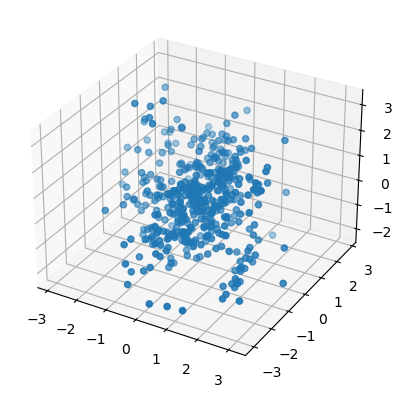

In [191]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scaled_intensity_hr_df['Min Hr'], scaled_intensity_hr_df['Max Hr'], scaled_intensity_hr_df['Daily Total Intensity'])
plt.show()

# K-means clustering

In [192]:
#! number of clusters?
model = KMeans(n_clusters=5, random_state=0)
kmeans_labels = model.fit_predict(scaled_intensity_hr_df.values)
# kmeans.labels_

In [195]:
scaled_intensity_hr_df.describe()

,Max Hr,Min Hr,Daily Total Intensity
count,4.690000e+02,4.690000e+02,4.690000e+02
mean,-2.666429e-15,-4.545049e-16,1.287764e-16
std,1.001068e+00,1.001068e+00,1.001068e+00
min,-3.042923e+00,-2.896353e+00,-2.175170e+00
25%,-6.196499e-01,-5.490019e-01,-6.588517e-01
50%,-1.101731e-01,-9.401252e-03,1.005794e-01
75%,6.690025e-01,5.521551e-01,6.442863e-01
max,2.809162e+00,3.098989e+00,3.196673e+00


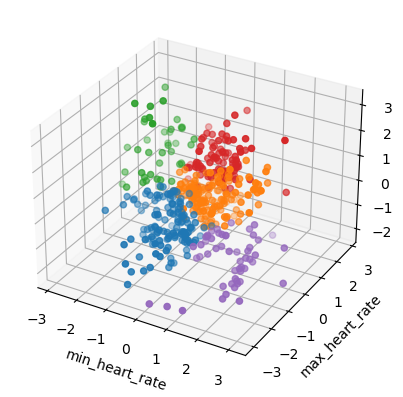

In [196]:
u_labels = np.unique(kmeans_labels)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in u_labels:
    ax.scatter(scaled_intensity_hr_df[kmeans_labels == i]['Min Hr'], scaled_intensity_hr_df[kmeans_labels == i]['Max Hr'], scaled_intensity_hr_df[kmeans_labels == i]['Daily Total Intensity'] , label = i)

plt.xlabel('min_heart_rate')
plt.ylabel('max_heart_rate')
ax.set_zlabel('intensity', fontsize=15, rotation=60)

plt.show()

In [198]:
scaled_intensity_hr_df.values

array([[ 1.81103599,  0.16850043,  0.68487207],
       [-1.70158254, -0.54900195, -0.63455287],
       [-0.33892917, -0.59804636,  0.32965778],
       ...,
       [ 0.28328653, -0.28884832, -0.25534876],
       [ 1.8857058 , -0.66400132,  0.92750092],
       [-0.62590184,  0.01871141, -0.92820769]])